In [4]:
#default_exp sort_images

# Generate the JSON files with images sorted by similarity

In [5]:
#exporti
from fastcore.script import *
from fastai.vision.all import *
from fastai.callback.wandb import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.barlow_twins import *

# fixup depreciation
from kornia import augmentation as korniatfm
korniatfm.GaussianBlur = korniatfm.RandomGaussianBlur

In [103]:
path = Path('../yolo-runs/runs/detect/exp4/crops/information--pedestrians-crossing--g1/')

In [104]:
data = np.load(path/'models/mlqa-model-resnet18-pretrained-224x50502-lr0.5e-3-1024vw.npz', allow_pickle=True)

In [105]:
bovw = np.unpackbits(data['bove'], axis=1)

In [106]:
fnames = [x.relative_to(Path('runs/detect/exp4/crops/information--pedestrians-crossing--g1/')) for x in data['fnames']]

In [115]:
#export
def load_bovw(fname):
    data = np.load(fname, allow_pickle=True)
    bovw = np.unpackbits(data['bovw'], axis=1)
    fnames = [x.relative_to(Path('runs/detect/exp4/crops/')) for x in data['fnames']]
    return bovw, fnames

In [127]:
#export
def nn_sort(features, start_idx=None):
    N = len(features)
    if N > 7000:
        idxs1, neighsim1 = nn_sort(features[:N//2])
        idxs2, neighsim2 = nn_sort(features[N//2:])
        return idxs1 + idxs2, neighsim1 + neighsim2

#     features = features.copy() - .5
    if start_idx is not None:
        x = features[start_idx]
    else:
        x = random.choice(features)
    remaining = list(range(len(features)))
    idxs = []
    neighsim = []
    for _ in progress_bar(range(len(remaining))):
        dists = x@features[remaining].T
        i = dists.argsort()[-1]
        neighsim.append(dists[i])
        idxs.append(remaining[i])
        x = features[remaining[i]]
        remaining.pop(i)
    return idxs, neighsim

In [128]:
#export
@call_parse
def sort_images(
        path:Path, # path
        features_file:str = None # features file
    ):
    "Pretrain a model on images in `path`."
    path = path/'models'
    if features_file is None:
        ffiles = list(path.glob('*vw.npz'))
        if len(ffiles) == 0:
            raise Exception(f"No BoVW files found in: {path}!")
        elif len(ffiles) > 1:
            msg = f"Found multiple BoVW files in: {path}, please pass one of:"
            for file in ffiles:
                msg += f"\n  --feature_file {file}"
            raise Exception(msg)
        features_file = ffiles[0]
        
    bovw, fnames = load_bovw(features_file)

    keyfunc = lambda x: fnames[x].parent
    groups = [(name.name, list(group))
              for name, group in itertools.groupby(sorted(range(len(fnames)), key=keyfunc), keyfunc)]
    with open((path.parent/Path(features_file).name.replace("-features", "-grouped")).with_suffix('.json'), 'w') as f:
        json.dump(dict(
            dist_threshold = 1000,
            labeled_clusters = [dict(
                name = f"{name} – sorted perceptualy",
                photos = [dict(
                    dist_to_mean=0, marked=False, murl=str(fnames[group[i]])
                ) for i in nn_sort(bovw[group])[0]]
            ) for name, group in groups]
        ), f)

In [129]:
sort_images(Path('../yolo-runs/runs/detect/exp4/crops/'))

In [108]:
idxs, neighsim = nn_sort(bovw)

(array([  2.,   4.,  18.,  43., 129., 191., 225., 172., 148.,  94., 134.,
         59.,  32.,  30.,  18.,  27.,   1.,   0.,   1.,   1.]),
 array([  7. ,  13.5,  20. ,  26.5,  33. ,  39.5,  46. ,  52.5,  59. ,
         65.5,  72. ,  78.5,  85. ,  91.5,  98. , 104.5, 111. , 117.5,
        124. , 130.5, 137. ]),
 <BarContainer object of 20 artists>)

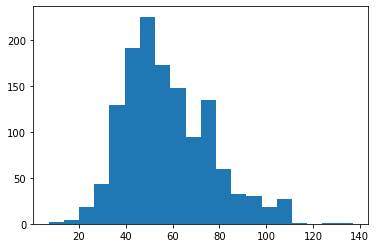

In [109]:
plt.hist(neighsim, bins=20)

In [110]:
[fnames[x] for x in idxs[:10]]

[Path('W7QW4ollquMVR5c6yi1FLw.jpg'),
 Path('3vJlFl2kt5ajcBjp4_krsw.jpg'),
 Path('skRjP6H867U_apcZyWxpbg.jpg'),
 Path('B3HXiK_C-zW-PshU9ozKhg.jpg'),
 Path('iR4PkjErdIvhOxQ4Tc3iZQ.jpg'),
 Path('6Wzx-zFBeNrL-cF6LkaCZQ.jpg'),
 Path('0KzJJtGvuTgH0g_0ZZwZRQ.jpg'),
 Path('boMHvmuxe8SnjtO69C77Gg.jpg'),
 Path('0R1RHiSbqZRjUMZu3hrUoQ.jpg'),
 Path('zghRkkIjw6sqmceqPoCoag.jpg')]

In [111]:
from IPython.display import display

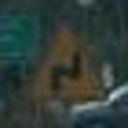

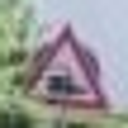

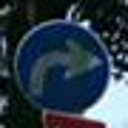

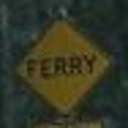

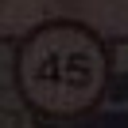

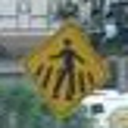

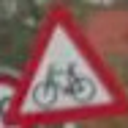

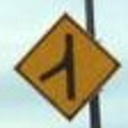

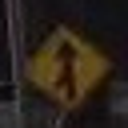

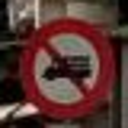

[None, None, None, None, None, None, None, None, None, None]

In [113]:
[display(PILImage.create(path/f).resize((128,128))) for f in _110]